In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten,Conv2D,MaxPool2D,LSTM,MaxPooling2D, Activation, AveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import activations
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score



from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from tensorflow.python.ops.numpy_ops import np_config


In [ ]:
# 압축파일 풀기기
# !unzip -qq "/content/drive/MyDrive/Colab Notebooks/car_ori.zip" -d "/content/drive/MyDrive/Colab Notebooks/car33"

In [ ]:
# 지정된 경로에서 파일 불러오기 
data_dir = '/content/drive/MyDrive/Colab Notebooks/car33'

In [ ]:
# Load training and validation sets
train_ds = image_dataset_from_directory(
    data_dir,validation_split=0.2,
    subset='training',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
val_ds = image_dataset_from_directory(
    data_dir,validation_split=0.2,
    subset='validation',
    labels='inferred',
    label_mode='categorical',
    image_size=[224, 224],
    seed=123,
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    train_ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    val_ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

class_names = train_ds.class_names
print(class_names)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 9900 files belonging to 33 classes.
Using 7920 files for training.
Found 9900 files belonging to 33 classes.
Using 1980 files for validation.
['AVANTE', 'CASPER', 'EV6', 'G70', 'GRANDEUR', 'GV60', 'IONIQ5', 'IONIQ6', 'K5', 'K8', 'K9', 'KONA', 'Korando', 'Morning', 'NEXO', 'NiroEV', 'PALISADE', 'Ray', 'Rexton', 'SANTAFE', 'SONATA', 'STARIA', 'Seltos', 'Sorento', 'Sportage', 'Stinger', 'TUCSON', 'Tivoli', 'Torres', 'VENUE', 'qm6', 'sm6', 'xm3']
(64, 224, 224, 3)
(64, 33)


In [ ]:
# 전이학습 -DenseNet121  
from tensorflow.keras.applications import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

num = 1
for layer in base_model.layers:
  if num>=312:
    layer.trainable = True
  else:
    layer.trainable = False
  num+=1

model = Sequential()

model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224,3)))

model.add(base_model)

model.add(Conv2D(16, 3, padding='same', activation='relu')) 
model.add(MaxPooling2D(padding='same')) 
model.add(Dropout(0.2))

model.add(Conv2D(32, 3, padding='same', activation='relu')) 
model.add(MaxPooling2D(padding='same'))

model.add(Conv2D(64, 3, padding='same', activation='relu')) 
model.add(MaxPooling2D(padding='same')) 
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu')) 
model.add(Dense(33 , activation = 'softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 16)          147472    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 4, 16)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 32)          46

In [ ]:
# 학습
hist = model.fit(ds_train,batch_size=64,epochs=20,validation_data=(ds_valid))

Epoch 1/20
124/124 [==============================] - 2237s 18s/step - loss: 3.5060 - accuracy: 0.0323 - val_loss: 3.5026 - val_accuracy: 0.0000e+00
Epoch 2/20
124/124 [==============================] - 33s 267ms/step - loss: 3.4392 - accuracy: 0.0485 - val_loss: 3.5192 - val_accuracy: 0.0000e+00
Epoch 3/20
124/124 [==============================] - 32s 259ms/step - loss: 3.3581 - accuracy: 0.0496 - val_loss: 3.4100 - val_accuracy: 0.0025
Epoch 4/20
124/124 [==============================] - 32s 258ms/step - loss: 3.3271 - accuracy: 0.0503 - val_loss: 3.3805 - val_accuracy: 5.0505e-04
Epoch 5/20
124/124 [==============================] - 32s 261ms/step - loss: 3.3089 - accuracy: 0.0511 - val_loss: 4.7348 - val_accuracy: 0.0000e+00
Epoch 6/20
124/124 [==============================] - 32s 260ms/step - loss: 3.2723 - accuracy: 0.0591 - val_loss: 3.4895 - val_accuracy: 0.0000e+00
Epoch 7/20
124/124 [==============================] - 32s 260ms/step - loss: 3.2301 - accuracy: 0.0631 - val_l

In [ ]:
# 전이학습 모델 특정 레이어에서 freeze 312
model.evaluate(ds_train),model.evaluate(ds_valid)

31/31 [==============================] - 6s 178ms/step - loss: 3.6122 - accuracy: 0.1490


([4.3437418937683105, 0.03080807998776436],
 [3.612220525741577, 0.14898990094661713])

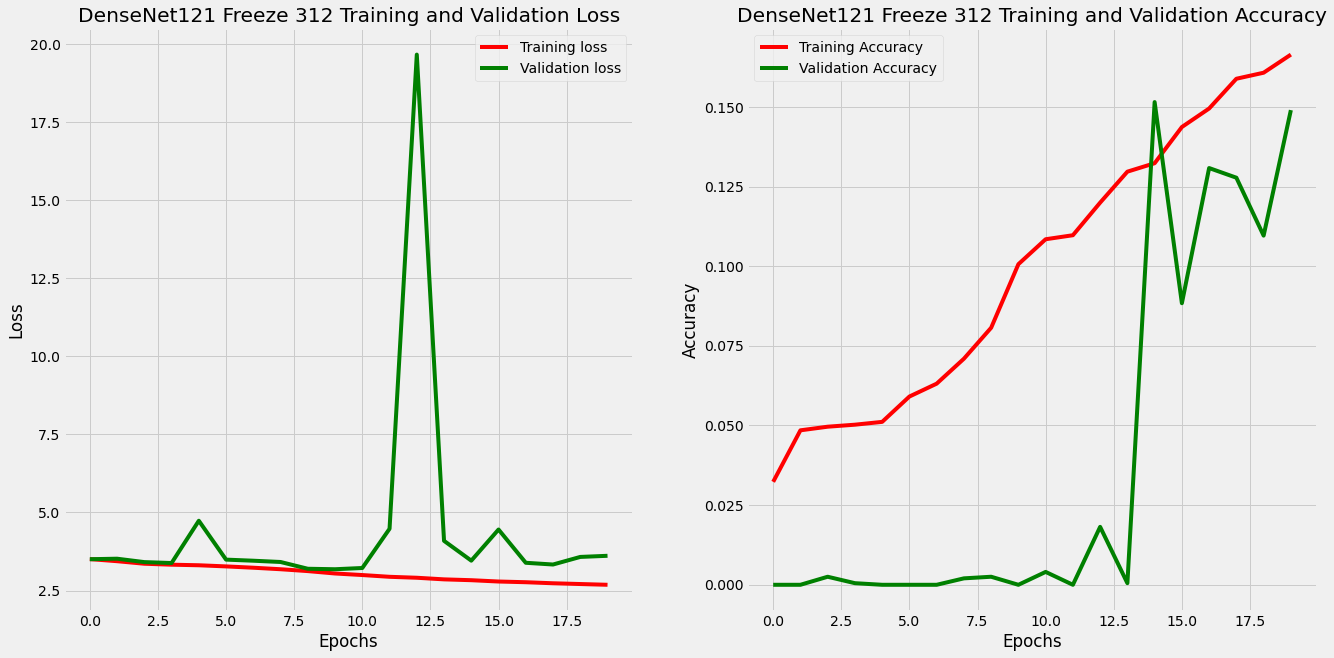

In [ ]:
# 시각화화
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('DenseNet121 Freeze 312 Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('DenseNet121 Freeze 312 Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/DenseNet121_f312.jpg")

In [ ]:
# 전이학습 모델 특정 레이어에서 freeze  63
model.evaluate(ds_train),model.evaluate(ds_valid)

31/31 [==============================] - 5s 174ms/step - loss: 0.2125 - accuracy: 0.9540


([0.04899502918124199, 0.9858585596084595],
 [0.21250829100608826, 0.9540404081344604])

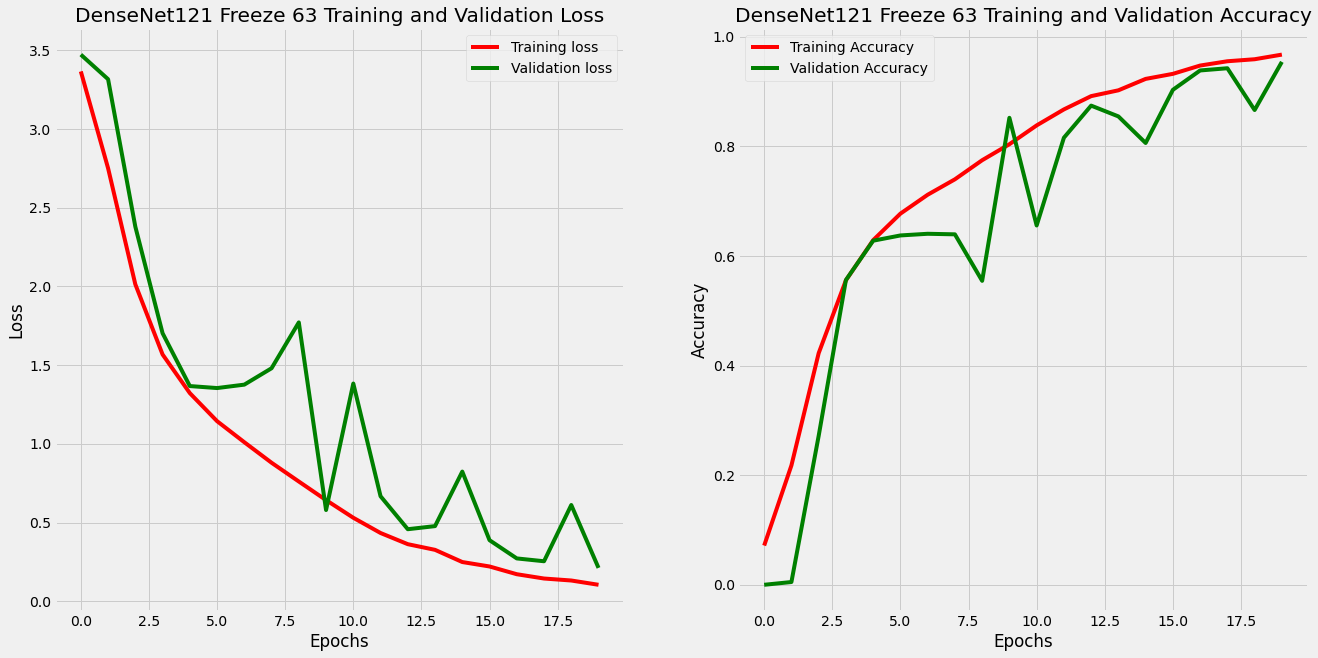

In [ ]:
# 시각화화
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('DenseNet121 Freeze 63 Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('DenseNet121 Freeze 63 Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/DenseNet121_f63.jpg")

In [ ]:
# freeze 59
model.evaluate(ds_train),model.evaluate(ds_valid)

31/31 [==============================] - 5s 174ms/step - loss: 4.6968 - accuracy: 0.2192


([4.196608066558838, 0.22032828629016876],
 [4.696831226348877, 0.21919192373752594])

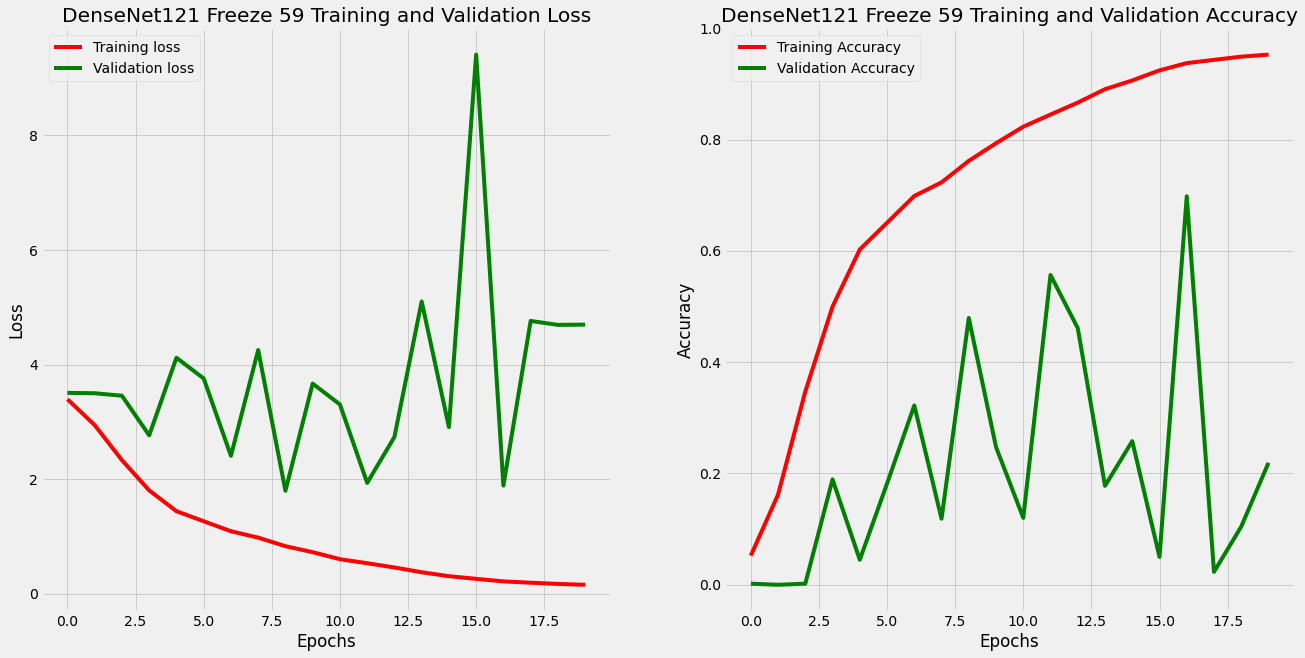

In [ ]:
# Visualization
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('DenseNet121 Freeze 59 Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('DenseNet121 Freeze 59 Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/DenseNet121_f59.jpg")

In [ ]:
# freeze 52
model.evaluate(ds_train),model.evaluate(ds_valid)

31/31 [==============================] - 5s 173ms/step - loss: 0.3003 - accuracy: 0.9182


([0.2720678150653839, 0.9263888597488403],
 [0.3003269135951996, 0.918181836605072])

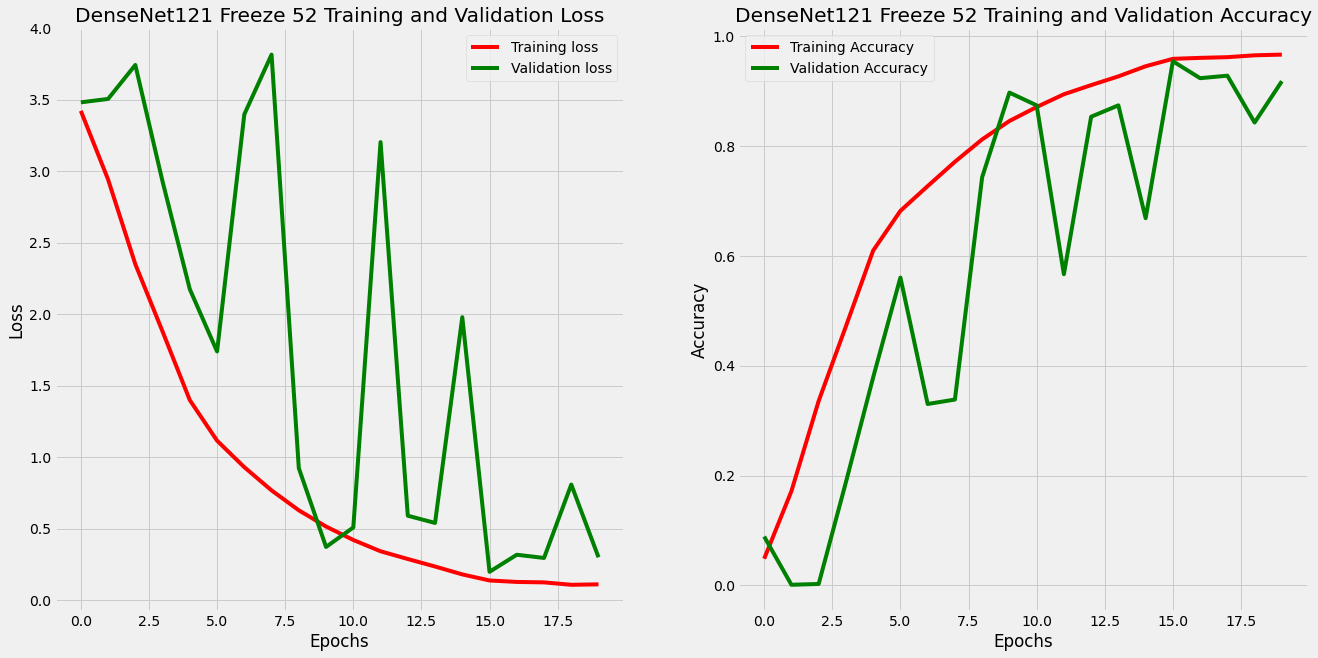

In [ ]:
# Visualization
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('DenseNet121 Freeze 52 Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('DenseNet121 Freeze 52 Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/DenseNet121_f52.jpg")

In [ ]:
# freeze 56
model.evaluate(ds_train),model.evaluate(ds_valid)

31/31 [==============================] - 5s 175ms/step - loss: 0.9670 - accuracy: 0.8035


([0.508719801902771, 0.883080780506134],
 [0.9670093655586243, 0.8035353422164917])

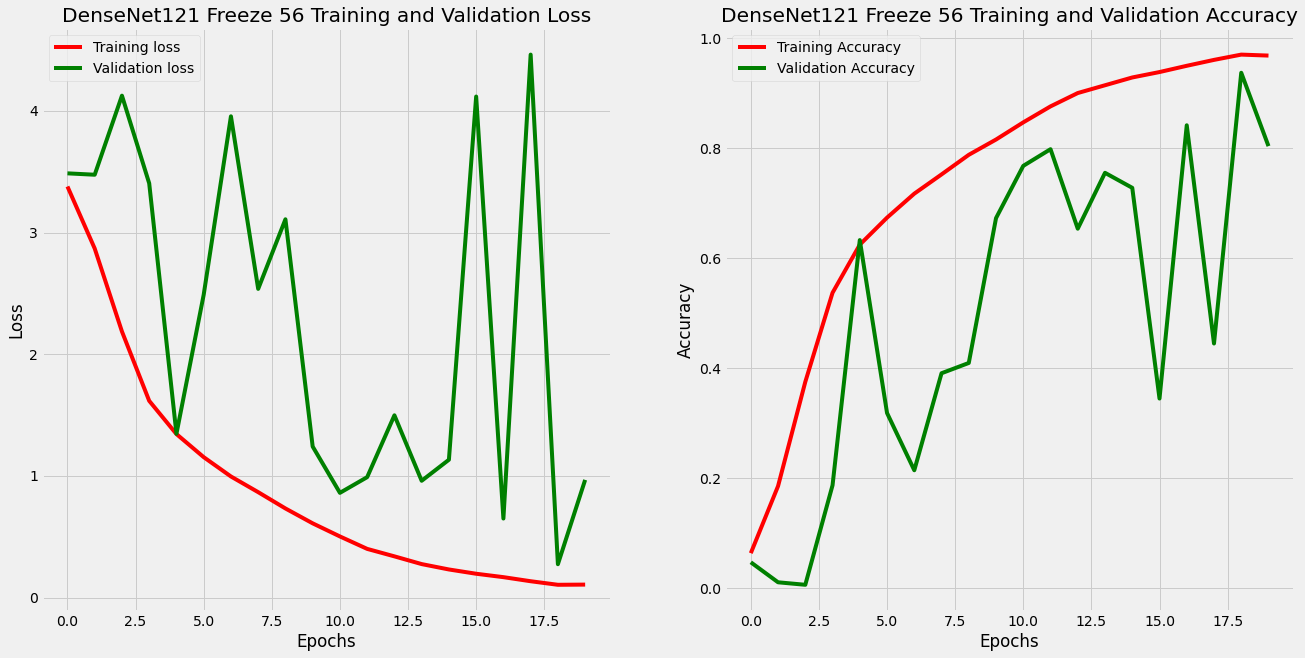

In [ ]:
# Visualization
plt.style.use('fivethirtyeight')
fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
axes[0].plot(hist.history["loss"], 'r', label='Training loss')
axes[0].plot(hist.history["val_loss"],'g',label='Validation loss' )
axes[0].set_title('DenseNet121 Freeze 56 Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[1].plot (hist.history["accuracy"],'r',label= 'Training Accuracy')
axes[1].plot (hist.history["val_accuracy"],'g',label= 'Validation Accuracy')
axes[1].set_title('DenseNet121 Freeze 56 Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.savefig("/content/drive/MyDrive/Colab Notebooks/DenseNet121_f56.jpg")